<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/07_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 重回帰による住宅価格の予測

* California housing datasetという有名なデータセットを使う。

* (scikit-learnからロードできるバージョンは、前処理が済んだキレイなデータなので、ここでは使わない。)

* データの取得や前処理の一部は、
[Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) の2章と同じ。

### 1) データを取得

In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

（ここより上の詳細はフォローしなくてもいいいです。）

In [0]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2) データを概観しつつ前処理

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [0]:
# 数値データではない列が一つだけある

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [0]:
# この数値データではない列を消してしまう

housing_num = housing.drop('ocean_proximity', axis=1)

In [0]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [0]:
# Non-Null Countが他より少ない列がある
# ここでは単に削除することにする

housing_num = housing_num.dropna(subset=['total_bedrooms'])

In [0]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB


In [0]:
# 説明変数と目的変数を分ける

X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"].copy()

### 3) 評価実験のための準備

In [0]:
# test setを取り除いておく

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4) 訓練データをよくよくながめてみる

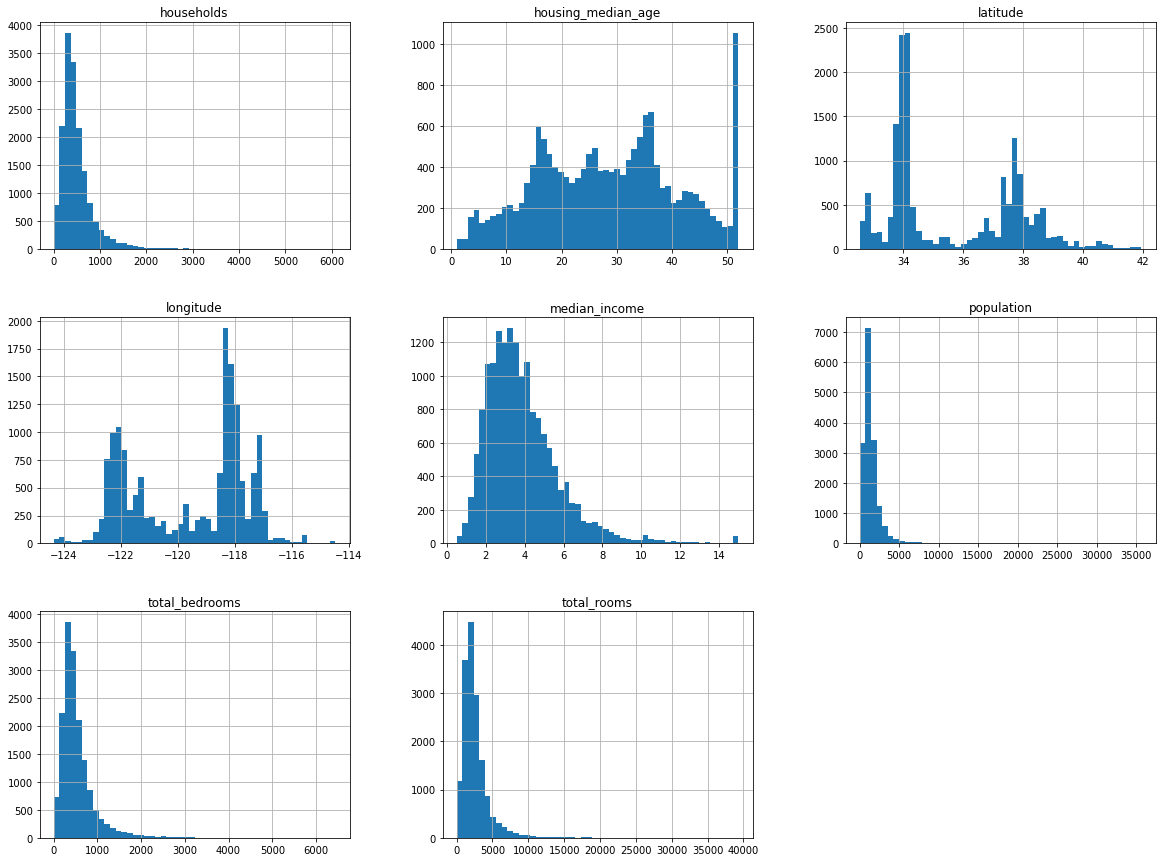

In [0]:
# ヒストグラムを描く
# (cf. Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. p.50)

import matplotlib.pyplot as plt

X_train.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# いくつかの属性の分布の形には注意したほうがいいかも・・・

X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000
mean,-119.580513,35.640569,28.615013,2626.293466,536.057751,1420.589991,497.613483,3.870697
std,2.005898,2.136181,12.577173,2153.306818,417.470689,1129.376716,377.997450,1.897825
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.810000,33.930000,18.000000,1450.000000,295.250000,787.000000,280.000000,2.564550
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1165.000000,408.000000,3.536650
75%,-118.010000,37.720000,37.000000,3131.750000,646.000000,1720.000000,603.000000,4.750000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


((array([-3.93039167, -3.71171935, -3.59195421, ...,  3.59195421,
          3.71171935,  3.93039167]),
  array([2.0000e+00, 6.0000e+00, 8.0000e+00, ..., 3.2054e+04, 3.2627e+04,
         3.9320e+04])),
 (1802.910618756396, 2626.293466291447, 0.8371088587948264))

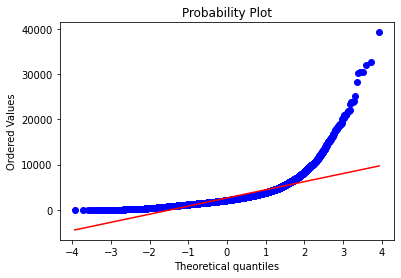

In [0]:
# total_roomsについて、正規分布からどのくらい外れているかを可視化する

from scipy import stats

stats.probplot(X_train.total_rooms, dist='norm', plot=plt)

((array([-3.93039167, -3.71171935, -3.59195421, ...,  3.59195421,
          3.71171935,  3.93039167]),
  array([ 0.75015664,  2.20705964,  2.65193702, ..., 41.47631182,
         41.65984282, 43.63774891])),
 (3.9416964481811543, 20.626878230086366, 0.9860662812758224))

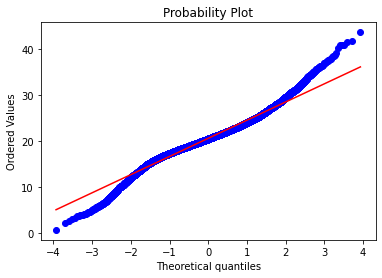

In [0]:
# Box-Cox変換してから再確認してみる

stats.probplot(stats.boxcox(X_train.total_rooms)[0], plot=plt)

(array([1.000e+00, 1.000e+00, 2.000e+00, 7.000e+00, 1.100e+01, 1.600e+01,
        2.600e+01, 2.200e+01, 2.800e+01, 4.000e+01, 4.500e+01, 7.000e+01,
        7.900e+01, 1.230e+02, 1.510e+02, 1.970e+02, 2.700e+02, 4.620e+02,
        7.090e+02, 1.061e+03, 1.382e+03, 1.722e+03, 1.734e+03, 1.675e+03,
        1.540e+03, 1.294e+03, 9.910e+02, 7.440e+02, 5.070e+02, 3.450e+02,
        2.860e+02, 2.260e+02, 1.400e+02, 1.110e+02, 9.100e+01, 7.000e+01,
        4.000e+01, 3.100e+01, 2.000e+01, 2.500e+01, 1.400e+01, 1.300e+01,
        9.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.75015664,  1.60790848,  2.46566033,  3.32341217,  4.18116402,
         5.03891586,  5.89666771,  6.75441955,  7.6121714 ,  8.46992325,
         9.32767509, 10.18542694, 11.04317878, 11.90093063, 12.75868247,
        13.61643432, 14.47418617, 15.33193801, 16.18968986, 17.0474417 ,
        17.90519355, 18.76294539, 19.62069724, 20.47844908, 21.33620093,
        22.

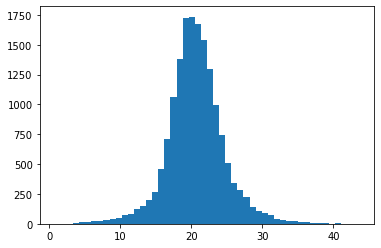

In [0]:
# ヒストグラムでも確認してみる

plt.hist(stats.boxcox(X_train.total_rooms)[0], bins=50)

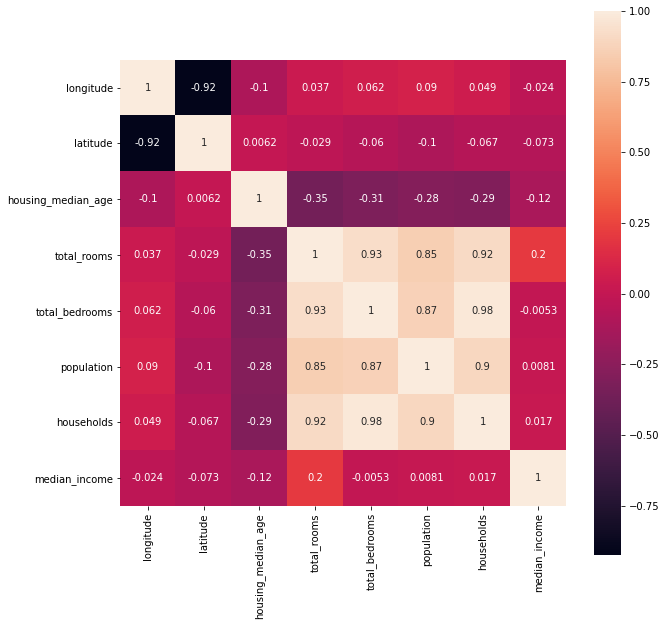

In [0]:
# 相関係数のヒートマップ

import seaborn as sns

plt.subplots(figsize=(10,10))
sns.heatmap(X_train.corr(), annot=True, square=True)

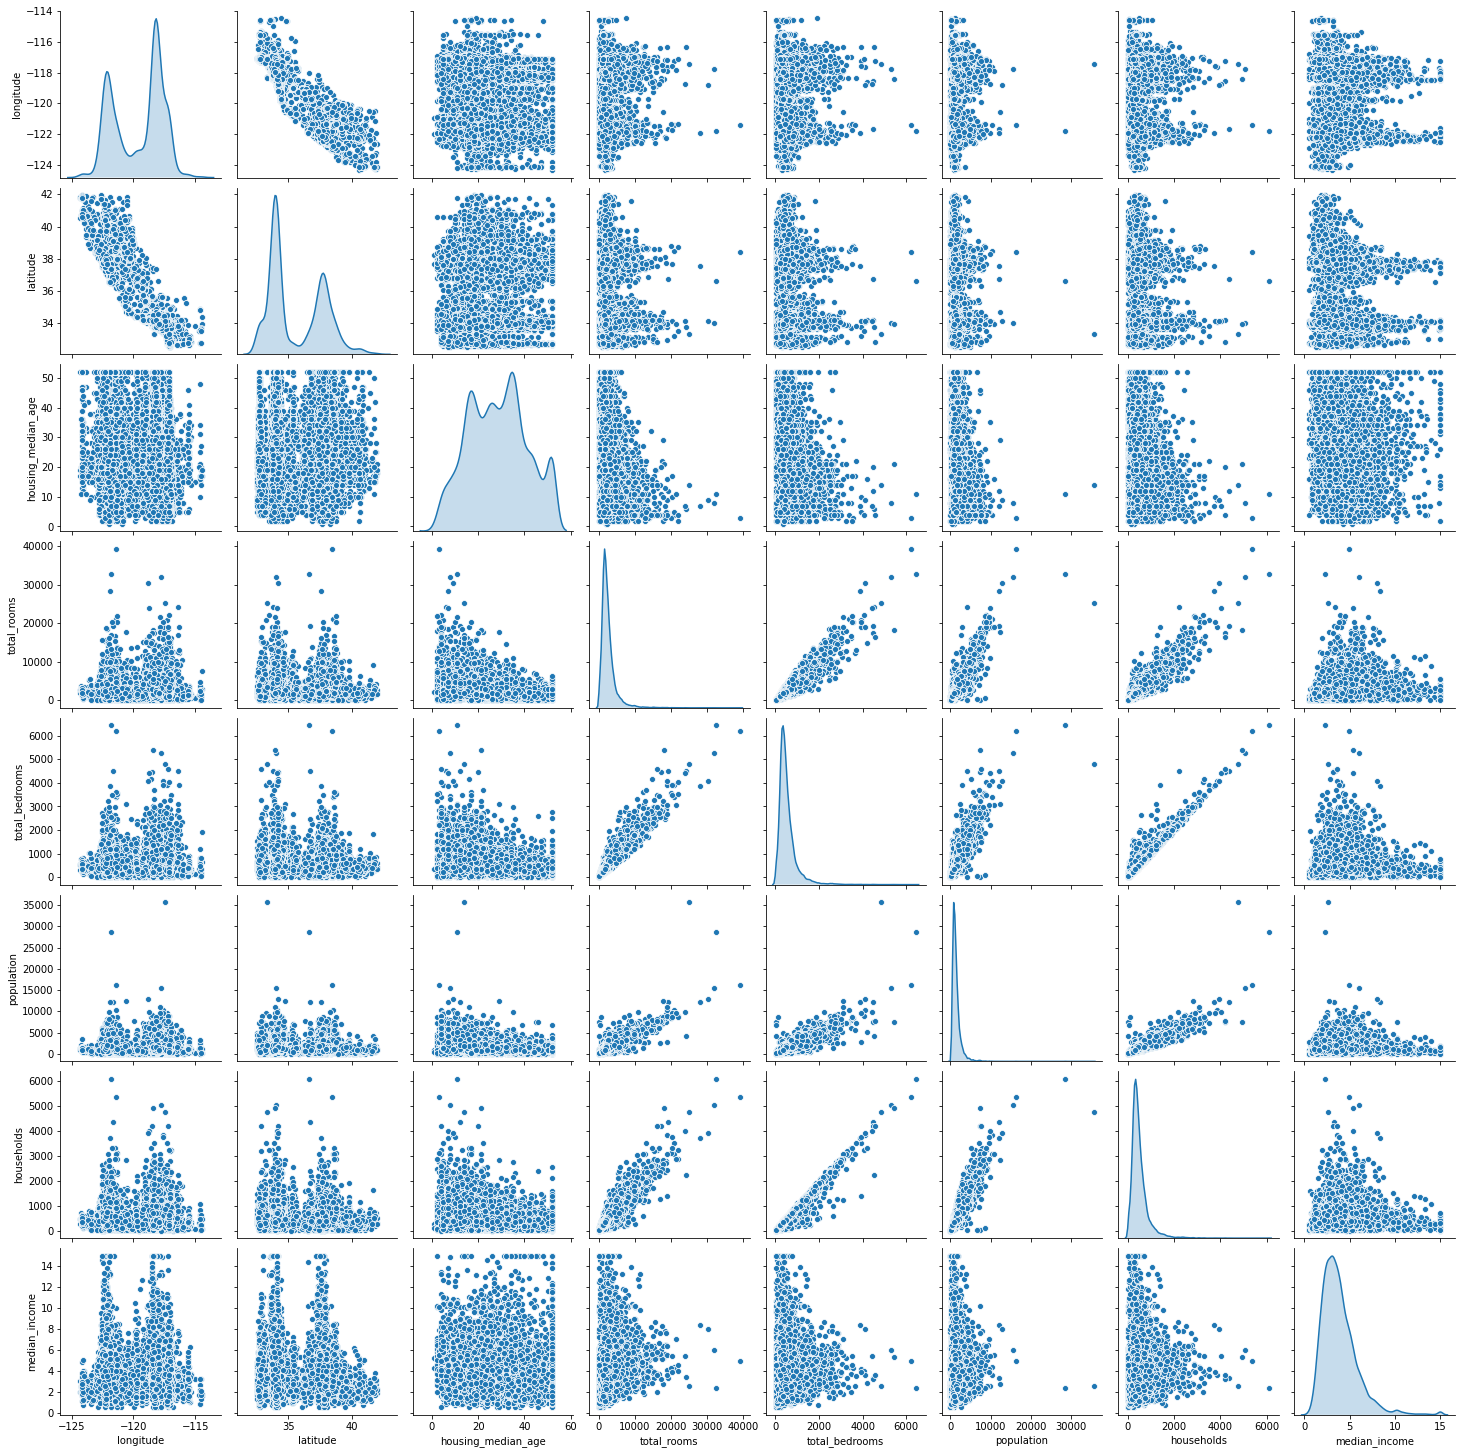

In [0]:
# seabornのpairplot

sns.pairplot(X_train, diag_kind='kde')

### 5) 交差検証の準備

In [0]:
# test set以外の残りを、training setとvalidation setに分ける

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
print(X_train.shape, X_valid.shape, X_test.shape)

(13076, 8) (3270, 8) (4087, 8)


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
# 先ほどのtraining set上でモデル・パラメータを決定する

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
reg.coef_

array([-4.21572133e+04, -4.19039659e+04,  1.18708545e+03, -7.52228680e+00,
        1.07613312e+02, -3.60945554e+01,  4.43276361e+01,  3.98126637e+04])

In [0]:
reg.intercept_

-3537642.7809097217

In [0]:
# 先ほどのvalidation set上で評価する

import numpy as np
from sklearn.metrics import mean_squared_error

y_valid_pred = reg.predict(X_valid)
print('RMSE: ', mean_squared_error(y_valid, y_valid_pred, squared=False))

RMSE:  67667.75807848654


# 課題7

* とにかく、RMSE(Root Mean Square Error)によって評価される予測性能を、良くして下さい。
* test setとそれ以外の部分の分割は、変えないでください。
* test set以外の部分をどう使うかは、自由です。
* LinearRegressionを必ず使うこと。（Ridge回帰やLassoはまだ使わないでください。）
* それ以外は、何をしても良いです。